In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import pymc3 as pm

Arka arkaya yaptığımız gözlemler her zaman aynı dağılımdan gelmeyebilir. Doğal şartlar veya sosyal durum değişebilir, ve gözlemlerimiz eskisinden farklı bir modele uymak zorunda kalabilir. Böyle bir değişimi veriye baktığımızda anlyabiliriz, ama tam ne zaman değiştiğini anlamakta zorlanabiliriz.

Örnek olarak, 1851-1962 arasında İngiltere'de gerçekleşen kömür madeni kazalarının verilerine bakalım. ([Kaynak](http://docs.pymc.io/notebooks/getting_started.html#Case-study-2:-Coal-mining-disasters))

(Arada iki yıl için veri mevcut olmadığı için bir NumPy masked array kullanıyoruz.)

/Users/huden/anaconda3/lib/python3.6/site-packages/matplotlib/patches.py:693: UserWarning: Warning: converting a masked element to nan.
  self._height = float(height)


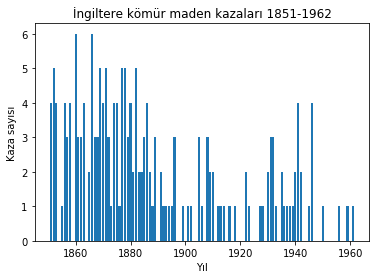

In [7]:
kaza_veri = np.ma.masked_equal([4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
                            3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
                            2, 2, 3, 4, 2, 1, 3, -999, 2, 1, 1, 1, 1, 3, 0, 0,
                            1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
                            0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
                            3, 3, 1, -999, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
                            0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1], value=-999)
yıllar = np.arange(1851, 1962)

plt.bar(yıllar, kaza_veri)
plt.title("İngiltere kömür maden kazaları 1851-1962")
plt.ylabel("Kaza sayısı")
plt.xlabel("Yıl");

İlk ve son yıllar arasında fark görüyoruz: 1900'lerde kazalar daha az, ve kazasız yıllar daha fazla. 1900 yılı civarında kaza oranlarında bir değişim olduğunu tahmin ediyoruz.

Bir yıl içinde _k_ maden kazası olması ihtimalini Poisson dağılımıyla modelleyebiliriz.

$$ p(k\ |\ \lambda) = \mathrm{e}^{-\lambda}\frac{\lambda^k}{k!}$$

Dağılımın $\lambda$ parametresi teorik olarak beklenen kaza sayısına eşittir.

Kazaların her zaman Poisson dağılımına uyduğunu, ama başta ve sondaki $\lambda$ parametrelerinin farklı olduğunu varsayarak model kuracağız. Değişim yılını bir rastgele değişken olarak ekleyelim.

In [13]:
with pm.Model() as kaza_modeli:

    # Değişim yılı için önsel: Yıllar üzerinde düzgün ayrık dağılım
    değişimyılı = pm.DiscreteUniform('değişimyılı', lower=yıllar.min(), upper=1910)
    değişimyılı2 = pm.DiscreteUniform('değişimyılı2', lower=1910, upper=yıllar.max(), testval=1910)

    # Değişimden önceki ve sonraki kaza sayıları oranlarının önselleri
    önceki_oran = pm.Exponential('önceki_oran', 1)
    orta_oran = pm.Exponential('orta_oran', 1)
    son_oran = pm.Exponential('son_oran', 1)

    # Değişim yılından önceki ve sonraki yıllara uygun Poisson oranları ata.
    oranlar = pm.math.switch(değişimyılı >= yıllar, önceki_oran, pm.math.switch(değişimyılı2 >= yıllar, orta_oran, son_oran))

    # Olabilirlik
    kazalar = pm.Poisson('kazalar', oranlar, observed=kaza_veri)

In [14]:
with kaza_modeli:
    zincir = pm.sample(10000)

Assigned Metropolis to değişimyılı
Assigned Metropolis to değişimyılı2
Assigned NUTS to önceki_oran_log_
Assigned NUTS to orta_oran_log_
Assigned NUTS to son_oran_log_
Assigned Metropolis to kazalar_missing
100%|██████████| 10000/10000 [00:56<00:00, 176.09it/s]


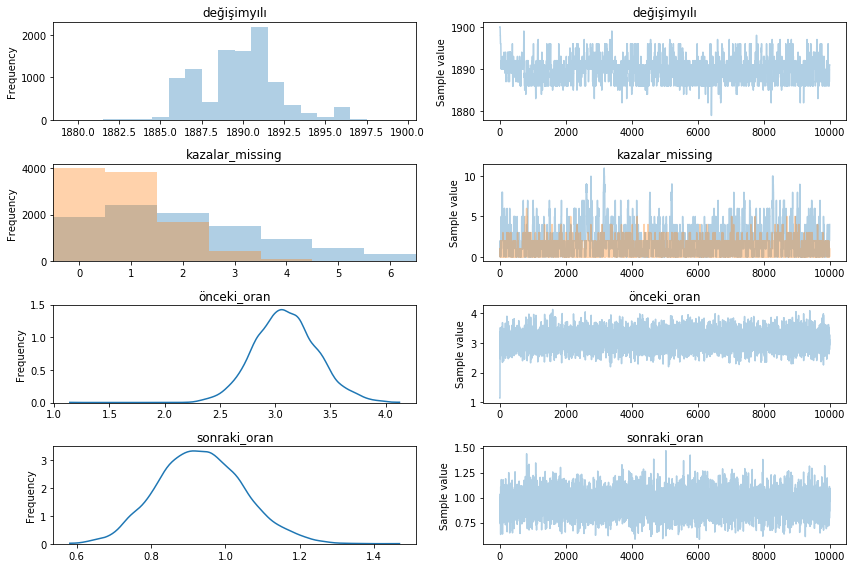

In [10]:
pm.traceplot(zincir);

In [11]:
pm.summary(zincir)


değişimyılı:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  1889.743         2.479            0.090            [1885.000, 1894.000]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  1886.000       1888.000       1890.000       1891.000       1896.000


kazalar_missing:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  2.196            1.895            0.092            [0.000, 6.000]
  0.893            0.922            0.029            [0.000, 3.000]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.000          1.000          2.000          3.000          7.000
  0.000       

Görüyoruz ki, 1888-1892 yılları arasında gerçekleşen bir değişim sayesinde, yılda üçten fazla olan maden kazası oranı, yılda birin altına düşmüş. 

## Çalışma

1. İki farklı parametre ile Poisson dağılımı kullanarak benzeri bir sentetik veri kümesi üretin ve modeli bu veriyle eğitin.

1. Hepsi aynı Poisson parametresiyle üretilen bir veri dizisi oluşturun ve modeli tekrar eğitin. Değişim noktası olarak ne elde ediyorsunuz?

1. *İki* değişim noktası, yani üç ayrı Poisson parametresi ile yeni bir sentetik veri dizisi oluşturun. Modeli iki değişim noktası kullanabilecek şekilde değiştirin ve eğitin.